# Model Evaluation Tutorial

## Topics
*  Motivation for model evaluation
*  Model training procedure
*  Model evaluation metrics:
 *  Accuracy
 *  Confusion matrix
 *  Precision, Recall, F1
 *  Receiver Operating Characteristic (ROC) Curves
 *  Area Under the Curve (AUC)

## Why are we already talking about model evaluation?

 *   We need a way to choose between different model types, tuning parameters, and features
 *   Model evaluation enables us to estimate how well a model will generalize to out-of-sample data
 *   A model evaluation metric (or many!) required to quantify the model performance


## Model training procedure:
1. Split the dataset into a **training** set and **testing** set.
> Put the testing data set aside and **do not use it for any part of model training**.
2. Further split your **training** set into a **training** and **validation** set.
3. Train the model on only the **training** data set.
4. Evaluate model performance on the **validation** set.
5. Repeat steps 2+ as necessary.
6. Only once the model has been finalized, should you evaluate on the left-out **testing** set.

## Training Model

In this notebook we will work with the [PIMA diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database/version/1). The goal is to predict whether or not a given female patient will contract diabetes based on certain diagnostic measurements that were recorded.
>This is a ***binary*** classification problem. Remember, an outcome value of 0 indicates that the patient does not have diabetes, while an outcome of 1 indicates that the patient does have diabetes. 

### Load Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Loading dataset
url = "https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/NotebookExampleData/Week1/diabetes.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

data = pd.read_csv(url, names=names)

# Dropping NaN rows
invalid = ['plas', 'pres', 'skin', 'test', 'mass']

# Replace 0's with NaN's in the "invalid" columns
for i in invalid:
    data[i].replace(to_replace=0, value=np.nan, inplace=True)

# Drop rows with NaN's, and drop the resultant indexing column
data = data.dropna(axis=0).reset_index(drop=True)
data.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
1,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
2,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
3,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
4,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


### Split data into training, validation, and test sets

In [ ]:
# Define your features (X) and labels (y)
X = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
y = 'class'

In [ ]:
from sklearn.model_selection import train_test_split

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[X], data[y], test_size=0.2, random_state=0)

# Further split X and y of training into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

### Train a model

Here we make use of a Decision Tree model. You don't have to worry about understanding the details for now; we'll be covering decision trees and other models more in depth later this week.

In [ ]:
# Train a decision tree model on the training set only
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4,random_state=0)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

## Model Evalutaion on Validation Data

For now, we will use the model to predict the binary classes of our validation data. Later we'll look at the case where our model outputs a probability over class labels.

In [ ]:
# Make class predictions for the training validation set
y_train_predict = model.predict(X_train)
y_val_predict = model.predict(X_val)

### Accuracy

In [ ]:
# Calculate model training accuracy
from sklearn import metrics
print('Training Accuracy:   {:01.3f}'.format(metrics.accuracy_score(y_train, y_train_predict)))

# Calculate model validation accuracy
print('Validation Accuracy: {:01.3f}'.format(metrics.accuracy_score(y_val, y_val_predict)))

Training Accuracy:   0.876
Validation Accuracy: 0.778


Notice that our **training accuracy** is higher than our **validation accuracy**.  This is fairly typical, as  machine learning algorithms have a tendency to overfit the training data.  When choosing a model, it's a good idea to tune it such that you are not overfitting too much.

![](https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/Images/Week1/fittings.jpg)

Okay, so our decision tree got ~78% validation accuracy.  But how do we know if that's a "good" accuracy?  Let's look at the simple case where we have a model that always predicts the most common class.  How well would that do?

In [ ]:
# Examine the class distribution of the validation set (using a Pandas Series method)
y_val.value_counts(normalize=True)

0    0.634921
1    0.365079
Name: class, dtype: float64

This means that a trivial model that always predicts 0 would be right ~63% of the time. So our decision tree seems to be doing something. 

However what if your training and validation dataset happened to have a bigger class imbalance? Say an imbalance of 90% negative and only 10% positive? If your model constantly predicts 0 you'd technically have a *really* good accuracy of 90%, but basing your metric on this metric alone can be misleading.

### Confusion Matrix



Now let's investigate the errors our model is making by looking at the **confusion matrix.** This is a simple way to tabulate the kinds of results our model is producing. It will follow the format shown below:

![](https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/Images/Week1/confusion%20matrix%202.png)

In this binary example shown above, are two possible predicted classes: negative (0) and positive (1). If we were predicting the presence of a disease, for example, positive would mean they have the disease, and negative would mean they don't have the disease.

- true positives (TP): Your model predicted positive, and the true label *is* positive
- true negatives (TN): Your model predicted negative, and the true label *is* negative
- false positives (FP): Your model predicted positive, but the true label is actually negative (Also known as a "Type I error")
- false negatives (FN): Your model predicted negative, but true label is actually positive (Also known as a "Type II error")


In [ ]:
# Use sklearn to make the confusion matrix
print('Confusion Matrix:')
labels = [0,1]
cm = metrics.confusion_matrix(y_val, y_val_predict)
print(cm)

# Normalized confusion matrix
print('\nNormalized Confusion Matrix:')
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

Confusion Matrix:
[[32  8]
 [ 6 17]]

Normalized Confusion Matrix:
[[0.8        0.2       ]
 [0.26086957 0.73913043]]


In [ ]:
# Or you can use pandas—it's a little nicer to look at
pd.crosstab(y_val, y_val_predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,32,8,40
1,6,17,23
All,38,25,63


We can also use a color heatmap to compare the frequency of each result type at a glance.

<ipython-input-11-19a1f71a56a2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels, fontsize=16)
<ipython-input-11-19a1f71a56a2>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels, fontsize=16)


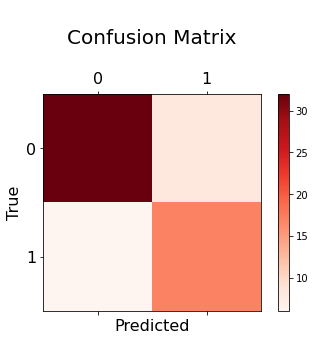

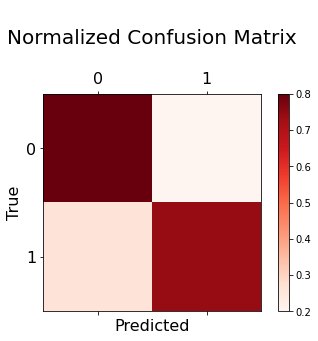

In [ ]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='Reds')
  plt.title('\n'+title+'\n', fontsize=20)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels, fontsize=16)
  ax.set_yticklabels([''] + labels, fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.show()
  
plot_cmatrix(cm,labels)
plot_cmatrix(cm_norm,labels,title='Normalized Confusion Matrix')

You can even make a confusion matrix for a multi-class problem! All we need to do is increase the number of squares, since there are more ways that a prediction can be right or wrong. Consider this example, predicting types of animals.

<ipython-input-11-19a1f71a56a2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels, fontsize=16)
<ipython-input-11-19a1f71a56a2>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels, fontsize=16)


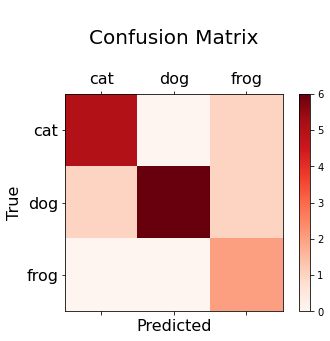

In [ ]:
# This series represents the true data
y2=pd.Series(['dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'frog', 'dog', 'dog', 'cat', 'frog'])
# This series represents a set of predictions
y2pred=pd.Series(['dog', 'cat', 'dog', 'dog', 'cat', 'frog', 'cat', 'cat', 'dog', 'cat', 'dog', 'frog', 'frog', 'dog', 'cat', 'frog'])

animal_labels=['cat','dog','frog']
cm = metrics.confusion_matrix(y2,y2pred)
plot_cmatrix(cm,animal_labels)

There are several useful metrics that are derived from the confusion matrix:
* sensitivity, recall, hit rate, or **true positive rate (TPR)** : $ \mathrm {TPR} ={\frac {\mathrm {TP} }{P}}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}$
 
* precision or **positive predictive value (PPV)** : $ \mathrm {PPV} ={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }}$

* specificity or **true negative rate (TNR)** : $\mathrm {TNR} ={\frac {\mathrm {TN} }{N}}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}$

* miss rate or **false negative rate (FNR)** : $ \mathrm {FNR} ={\frac {\mathrm {FN} }{P}}={\frac {\mathrm {FN} }{\mathrm {FN} +\mathrm {TP} }}=1-\mathrm {TPR}$

* fall-out or **false positive rate (FPR)** : $\mathrm {FPR} ={\frac {\mathrm {FP} }{N}}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}=1-\mathrm {TNR} $

* **accuracy (ACC)** : $\mathrm {ACC} ={\frac {\mathrm {TP} +\mathrm {TN} }{P+N}}={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {TP} +\mathrm {TN} +\mathrm {FP} +\mathrm {FN} }}$

## F1 score

The **F1 score** is the harmonic mean of precision and recall. The best possible F1 score would be 1, and worst would be 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
 * F1 score: $F_{1}=2\cdot {\frac {\mathrm {PPV} \cdot \mathrm {TPR} }{\mathrm {PPV} +\mathrm {TPR} }}={\frac {2\mathrm {TP} }{2\mathrm {TP} +\mathrm {FP} +\mathrm {FN} }}$

Let's calculate the precision, recall, and F1 values for the model we created earlier.

In [ ]:
print('Precision: {:01.3f}'.format(metrics.precision_score(y_val,y_val_predict)))
print('Recall:    {:01.3f}'.format(metrics.accuracy_score(y_val,y_val_predict)))
print('F1 score:  {:01.3f}'.format(metrics.f1_score(y_val,y_val_predict)))

Precision: 0.680
Recall:    0.778
F1 score:  0.708


## Outputting Probabilities 

Up to now, we've simply been evaluating our model's ability to predict the correct class. But in most practical cases, we will want a model to output a *probability* or *certainty* rather than class labels. Fortunately, the sklearn model we created can already calculate probabilities for us. Let's consider the classification probabilities for a single entry.

In [ ]:
# Predict class label probabilities
labels = [0,1]
y_val_prob = model.predict_proba(X_val,labels)

# Output predicted and true values for the first validation point
print('Probabilities:\n',y_val_prob[0])
print('\nTrue Value:\n',y_val.values[0])

Probabilities:
 [0.21917808 0.78082192]

True Value:
 1


Notice that the decision tree predicts that there is a ~78% probability that this entry belongs to class label 1. This doesn't necessarily mean we *have* to label the entry as class 1. For example, we may decide to say that 90% confidence is required for an entry to be assigned class 1, otherwise it belongs to class 0. The predicted class will depend on where we threshold our decision boundary.

Choosing a threshold is not always as straighforward as choosing the label with the greatest probability. If we know a data set to be biased, or if there is a greater penalty for either false positives or false negatives, it can often be desirable to evaluate the model over a range of thresholds. This is where the **Receiver Operating Characteristic (ROC) curve** comes in!

### ROC Curves and AUC

The **Receiver Operating Characteristic curve**, or **ROC curve**, is a plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. That is to say, it shows how good the classifier is at different thresholds. It is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

Often, the **area under the (ROC) curve,** or **AUC**, is used as a robust and descriptive metric of a classification model's performance. 
>An AUC of 1 is "perfect," and an AUC of .5 means that the classifier is no better than random.

To describe what the AUC means, consider that a model's prediction of the chance for an entry to be in a class to be that entry's "score." Then, the AUC is the probability that a randomly chosen entry that truly is in that class will have a higher "score" than a random entry that is not in that class.

In [ ]:
# Calculate the FPR and TPR at varying thresholds (assume label 1 is the "postive" class)
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_prob[:,1])

# Calculate the area under the ROC curve
roc_auc = metrics.auc(fpr, tpr)

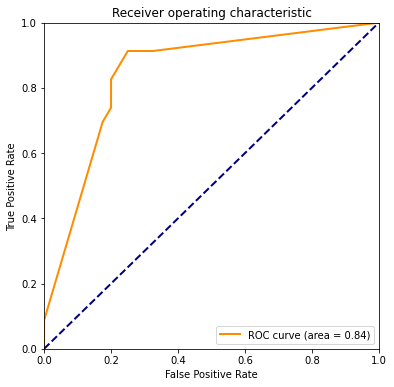

In [ ]:
# Plot the ROC curve
plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Next Steps

There is no separate exercise notebook for this section, but here are a few things to do on your own:
* Perform the same analysis above using [k-fold cross validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
* Choose a "good" threshold for the decision tree created above (according to some metric, e.g., minimizing False Positives)
* Evaluate the TEST data using the model at your chosen threshold -- how does the classifier perform?

*Note: This tutorial is derived from Data School's Machine Learning with scikit-learn tutorial.*

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=26f50753-0d12-4093-845a-7bba6b33ce3f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>